Bonjour et bienvenu(e)s dans cette abomination. 

Mon but ultimes à la fin serait d'avoir dans un premier temps un modèle qui dit à quel % un patient est atteint de quelques chose (quelque soit cette chose). Ensuite un second qui dit "Bon si ce patient est malade, il a ça à x%, ça a y% ...etc"

Puisque ce sont des données medicales, je m'autorise d'avoir des False Positive, c'est à dire que je préfère un modèle qui annoce un cancer alors qu'on ne l'a pas plutôt qu'un modèle qui se trompe en ne l'annonçant pas.


# Enlevez le markdown ci-dessous si nécessaire

!pip install imbalanced-learn  # Ou !conda install -c conda-forge imbalanced-learn -y

import os
#os._exit(00)  # Redémarrer le noyau (ou le faire manuellement)

import imblearn
print(imblearn.__version__)  # Vérifier l'installation

!pip show imbalanced-learn  # Vérifier l'environnement d'installation

##### Si toujours pas installé dans le bon environnement
!pip install --user imbalanced-learn  
##### Ou avec conda (remplace "your_env" par ton environnement)
!conda install -n your_env -c conda-forge imbalanced-learn

!pip install 'aif360[inFairness]'
!pip install 'aif360[Reductions]'
!pip install 'aif360[Reweighing]'

!pip install --upgrade pip
!pip install iterstrat


In [1]:
import imblearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler



import plotly.express as px
import plotly.graph_objects as go

from scipy.sparse import csr_matrix

from aif360.sklearn.metrics import *
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing.lfr import LFR
from aif360.algorithms.preprocessing import *
from aif360.sklearn.metrics import selection_rate
from aif360.sklearn.metrics import *



2025-02-16 22:43:29.617131: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/torch/_functorch/deprecated.py:58: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


## Visualisation des données

In [ ]:
df = pd.read_csv("KERMADJ_ZINEDDINE.csv") 
df

Image Index          Finding Labels  Follow-up #  Patient ID  \
0      00000001_000.png            Cardiomegaly            0           1   
1      00000001_001.png  Cardiomegaly|Emphysema            1           1   
2      00000001_002.png   Cardiomegaly|Effusion            2           1   
3      00000005_000.png              No Finding            0           5   
4      00000005_001.png              No Finding            1           5   
...                 ...                     ...          ...         ...   
54933  00030794_000.png              No Finding            0       30794   
54934  00030796_000.png              No Finding            0       30796   
54935  00030802_000.png              No Finding            0       30802   
54936  00030803_000.png              No Finding            0       30803   
54937  00030804_000.png              No Finding            0       30804   

       Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0               58              M            PA                 2682     2749   
1               58              M            PA                 2894     2729   
2               58              M            PA                 2500     2048   
3               69              F            PA                 2048     2500   
4               69              F            AP                 2500     2048   
...            ...            ...           ...                  ...      ...   
54933           38              F            PA                 2021     2021   
54934           44              M            PA                 2021     2021   
54935           29              M            PA                 2048     2500   
54936           42              F            PA                 2048     2500   
54937           30              F            PA                 2048     2500   

       OriginalImagePixelSpacing[x        y]  Unnamed: 11  
0                         0.143000  0.143000          NaN  
1                         0.143000  0.143000          NaN  
2                         0.168000  0.168000          NaN  
3                         0.168000  0.168000          NaN  
4                         0.168000  0.168000          NaN  
...                            ...       ...          ...  
54933                     0.194311  0.194311          NaN  
54934                     0.194311  0.194311          NaN  
54935                     0.168000  0.168000          NaN  
54936                     0.168000  0.168000          NaN  
54937                     0.168000  0.168000          NaN  

[54938 rows x 12 columns]

In [3]:
print("\nDimensions du dataset :")
print(df.shape)  # (lignes, colonnes)

print("\nListe des colonnes :")
print(df.columns)

print("\nTypes de données :")
print(df.dtypes)

print("\nValeurs manquantes par colonne :")
print(df.isnull().sum())

print("\nStatistiques générales :")
print(df.describe())  # Statistiques des colonnes numériques



Dimensions du dataset :
(54938, 12)

Liste des colonnes :
Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'],
      dtype='object')

Types de données :
Image Index                     object
Finding Labels                  object
Follow-up #                      int64
Patient ID                       int64
Patient Age                      int64
Patient Gender                  object
View Position                   object
OriginalImage[Width              int64
Height]                          int64
OriginalImagePixelSpacing[x    float64
y]                             float64
Unnamed: 11                    float64
dtype: object

Valeurs manquantes par colonne :
Image Index                        0
Finding Labels                     0
Follow-up #                        0
Patient ID                         0
Patient Age    

On voit immédiatement que la colonne supprimée ci-dessous est vide. Si pas convaincus ou pour plus d'automatisme, on peut supprimer une colonne suivant un seuil

In [4]:
df = df.drop(columns=['Unnamed: 11'])

df

Image Index          Finding Labels  Follow-up #  Patient ID  \
0      00000001_000.png            Cardiomegaly            0           1   
1      00000001_001.png  Cardiomegaly|Emphysema            1           1   
2      00000001_002.png   Cardiomegaly|Effusion            2           1   
3      00000005_000.png              No Finding            0           5   
4      00000005_001.png              No Finding            1           5   
...                 ...                     ...          ...         ...   
54933  00030794_000.png              No Finding            0       30794   
54934  00030796_000.png              No Finding            0       30796   
54935  00030802_000.png              No Finding            0       30802   
54936  00030803_000.png              No Finding            0       30803   
54937  00030804_000.png              No Finding            0       30804   

       Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0               58              M            PA                 2682     2749   
1               58              M            PA                 2894     2729   
2               58              M            PA                 2500     2048   
3               69              F            PA                 2048     2500   
4               69              F            AP                 2500     2048   
...            ...            ...           ...                  ...      ...   
54933           38              F            PA                 2021     2021   
54934           44              M            PA                 2021     2021   
54935           29              M            PA                 2048     2500   
54936           42              F            PA                 2048     2500   
54937           30              F            PA                 2048     2500   

       OriginalImagePixelSpacing[x        y]  
0                         0.143000  0.143000  
1                         0.143000  0.143000  
2                         0.168000  0.168000  
3                         0.168000  0.168000  
4                         0.168000  0.168000  
...                            ...       ...  
54933                     0.194311  0.194311  
54934                     0.194311  0.194311  
54935                     0.168000  0.168000  
54936                     0.168000  0.168000  
54937                     0.168000  0.168000  

[54938 rows x 11 columns]

In [5]:
print(df['Patient Gender'].unique())  
print(df['View Position'].unique())  

print(df['Finding Labels'].value_counts())

['M' 'F']
['PA' 'AP']
Finding Labels
No Finding                                          29640
Infiltration                                         4763
Atelectasis                                          1984
Effusion                                             1914
Nodule                                               1284
                                                    ...  
Consolidation|Edema|Effusion|Mass|Nodule                1
Effusion|Hernia|Infiltration                            1
Emphysema|Fibrosis|Mass                                 1
Edema|Effusion|Emphysema|Infiltration                   1
Effusion|Fibrosis|Mass|Nodule|Pleural_Thickening        1
Name: count, Length: 625, dtype: int64


In [6]:
df_filtered = df[['Patient ID', 'Finding Labels']].copy()
df_filtered['Maladies'] = df_filtered['Finding Labels'].str.split('|')

#print(df)
df_exploded = df_filtered.explode('Maladies')

df_no_other = df_exploded.groupby('Patient ID').filter(lambda x: (x['Maladies'] == 'No Finding').all())
df_no_other = df_no_other.drop_duplicates()
print(f"Sains: {df_no_other.shape[0]} personnes")
df_no_other

Sains: 8090 personnes


Patient ID Finding Labels    Maladies
11              6     No Finding  No Finding
12              7     No Finding  No Finding
71             14     No Finding  No Finding
82             29     No Finding  No Finding
166            46     No Finding  No Finding
...           ...            ...         ...
54933       30794     No Finding  No Finding
54934       30796     No Finding  No Finding
54935       30802     No Finding  No Finding
54936       30803     No Finding  No Finding
54937       30804     No Finding  No Finding

[8090 rows x 3 columns]

In [7]:
#df_exploded['has_other_disease'] = df_exploded['Maladies'] != 'No Finding'
df_exploded = df_exploded[df_exploded['Maladies'] != 'No Finding']
df_exploded = df_exploded.drop_duplicates(["Maladies","Patient ID"])

#df_grouped = df_exploded.groupby('Patient ID').apply(lambda x: x[~((x['Maladies'] == 'No Finding') & (x['has_other_disease'] == True))])#.reset_index(drop=True)
print(f"Malades {df_exploded.shape[0]}")
df_exploded

Malades 16895


Patient ID                                Finding Labels  \
0               1                                  Cardiomegaly   
1               1                        Cardiomegaly|Emphysema   
2               1                         Cardiomegaly|Effusion   
9               5                                  Infiltration   
10              5                         Effusion|Infiltration   
...           ...                                           ...   
54925       30786  Cardiomegaly|Effusion|Emphysema|Pneumothorax   
54929       30786                                 Consolidation   
54930       30786              Consolidation|Pleural_Thickening   
54932       30793                                   Mass|Nodule   
54932       30793                                   Mass|Nodule   

                 Maladies  
0            Cardiomegaly  
1               Emphysema  
2                Effusion  
9            Infiltration  
10               Effusion  
...                   ...  
54925        Cardiomegaly  
54929       Consolidation  
54930  Pleural_Thickening  
54932                Mass  
54932              Nodule  

[16895 rows x 3 columns]

In [8]:
maladie_counts = df_exploded['Maladies'].value_counts()
#maladie_counts['No Finding'] = df_no_other['Maladies'].count()

print(maladie_counts)

#df_unique = df_filtered.drop_duplicates(subset=['Patient ID', 'Maladies'])

#maladie_counts = df_unique['Maladies'].value_counts()

#df_exploded = df_filtered.assign(Maladies=df['Finding Labels'].str.split('|')).explode('Finding Labels')
#df_unique = df_exploded.drop_duplicates(subset=['Patient ID', 'Finding Labels'])



Maladies
Infiltration          3908
Atelectasis           2428
Effusion              2054
Nodule                1629
Mass                  1190
Consolidation         1056
Pleural_Thickening     957
Cardiomegaly           750
Pneumothorax           722
Fibrosis               612
Edema                  529
Pneumonia              498
Emphysema              494
Hernia                  68
Name: count, dtype: int64


## Dessinons

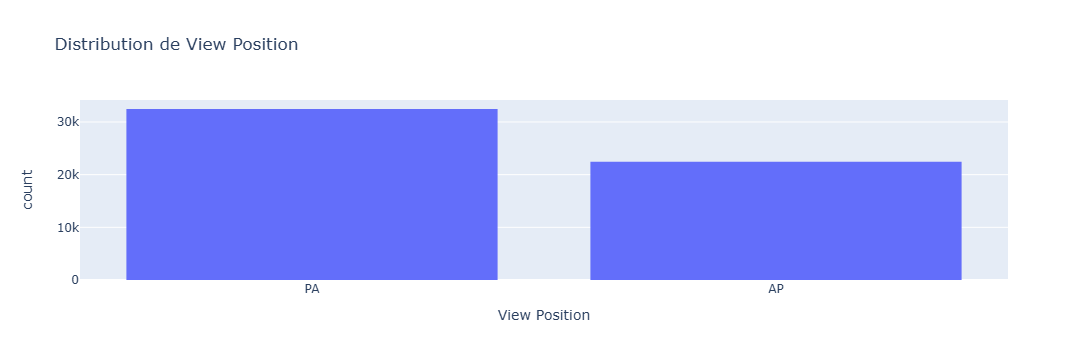

In [9]:
""""
for col in df.select_dtypes(include=['object', 'category']):
    fig = px.histogram(df, x=col, title=f"Distribution de {col}")
    fig.show()"""

fig = px.histogram(df, x="View Position" , title=f"Distribution de View Position")
fig.show()

Il se peut que la disparité entre les view position pose problème. (Une étude plutard prouvera le contraire et une simple recherche sur internet apportera des réponses)

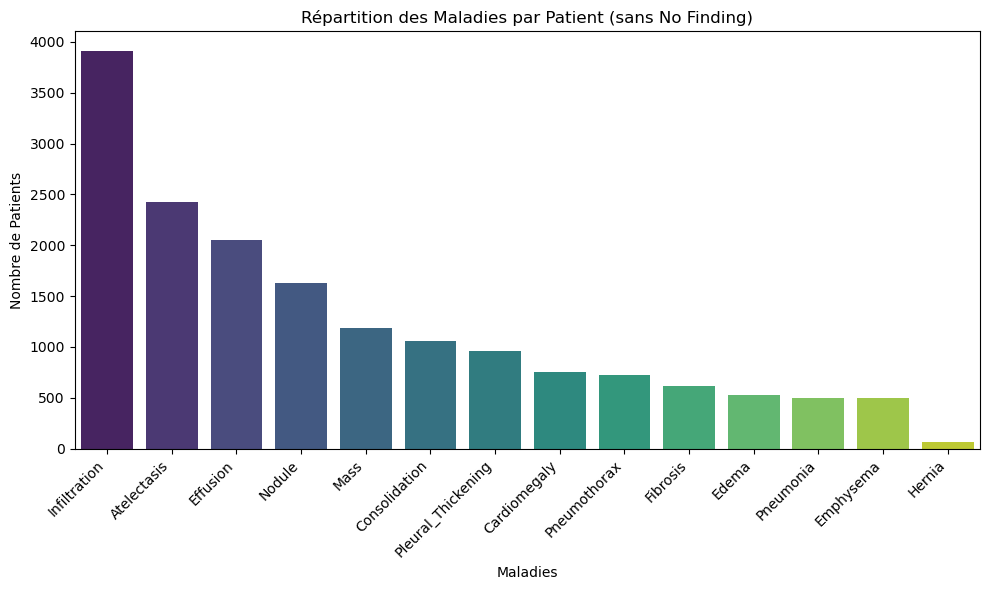

In [10]:
plt.figure(figsize=(10,6))
sns.barplot(x=maladie_counts.index, y=maladie_counts.values, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Maladies')
plt.ylabel('Nombre de Patients')
plt.title('Répartition des Maladies par Patient (sans No Finding)')
plt.tight_layout()
plt.show()

Là, c'est clair que des maladies vont sauter. Mon modèle ne prédira pas l'hérnie car je n'ai pas assez de données sur cette dernière: Même pas assez pour que SMOTE soit efficace.

In [11]:
df_distribution = df_exploded.merge(df[['Patient ID', 'Patient Age', 'Patient Gender']], on='Patient ID', how='left')

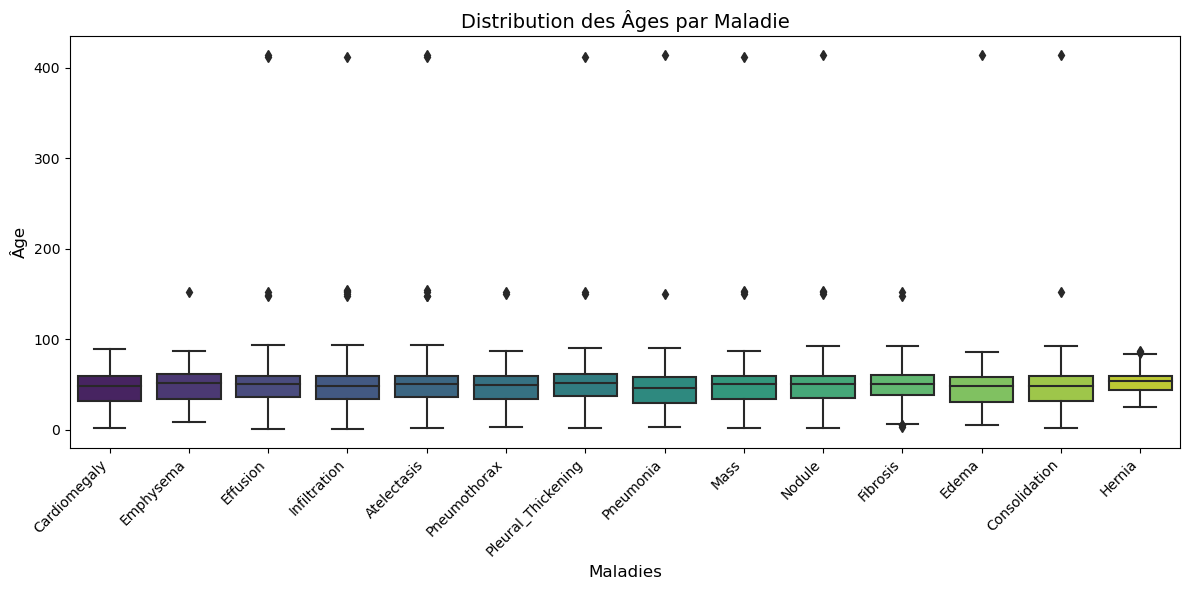

In [12]:
# Boxplot pour voir la distribution de l'âge par maladie
plt.figure(figsize=(12, 6))
sns.boxplot(x='Maladies', y='Patient Age', data=df_distribution, palette='viridis')

# Ajouter des titres et labels
plt.title('Distribution des Âges par Maladie', fontsize=14)
plt.xlabel('Maladies', fontsize=12)
plt.ylabel('Âge', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

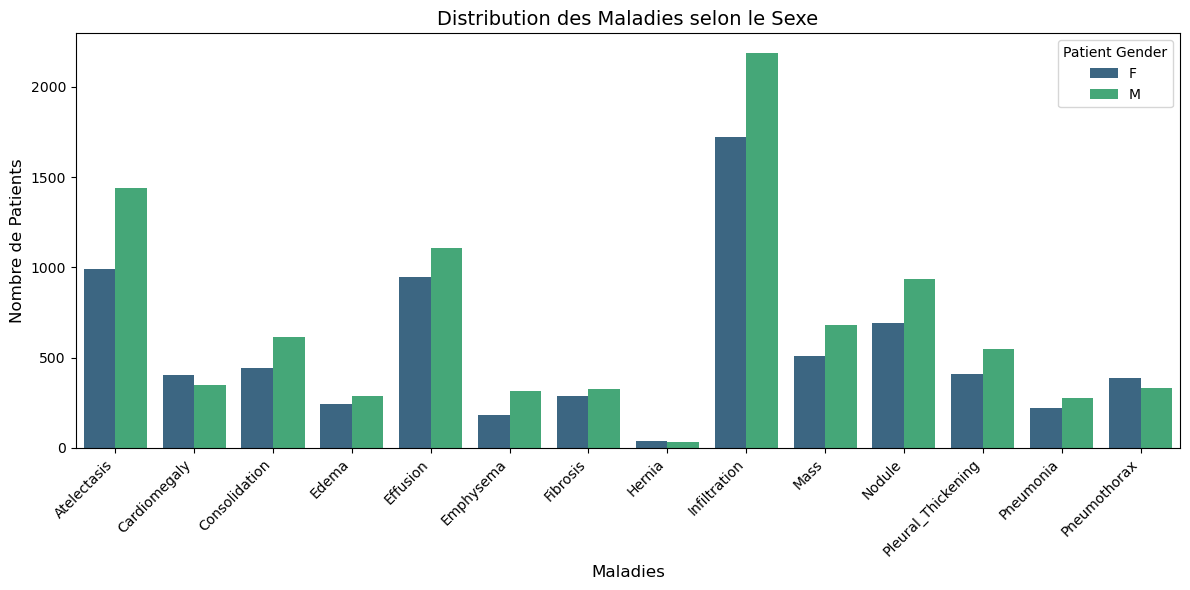

In [13]:
# Fusionner pour ajouter le genre des patients
df_maladie_count = df_exploded.merge(df[['Patient ID', 'Patient Gender']], on='Patient ID', how='left').drop_duplicates()

# Compter le nombre de patients atteints de chaque maladie par genre
df_maladie_count = df_maladie_count.groupby(['Maladies', 'Patient Gender']).size().reset_index(name='Nombre de Patients')

# Création du barplot
plt.figure(figsize=(12, 6))
sns.barplot(x='Maladies', y='Nombre de Patients', hue='Patient Gender', data=df_maladie_count, palette='viridis')

# Ajouter des titres et labels
plt.title('Distribution des Maladies selon le Sexe', fontsize=14)
plt.xlabel('Maladies', fontsize=12)
plt.ylabel('Nombre de Patients', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


Vu comme ça, ça vaaaa

In [14]:
df_maladie_count

Maladies Patient Gender  Nombre de Patients
0          Atelectasis              F                 990
1          Atelectasis              M                1438
2         Cardiomegaly              F                 402
3         Cardiomegaly              M                 348
4        Consolidation              F                 441
5        Consolidation              M                 615
6                Edema              F                 243
7                Edema              M                 286
8             Effusion              F                 947
9             Effusion              M                1107
10           Emphysema              F                 182
11           Emphysema              M                 312
12            Fibrosis              F                 287
13            Fibrosis              M                 325
14              Hernia              F                  37
15              Hernia              M                  31
16        Infiltration              F                1720
17        Infiltration              M                2188
18                Mass              F                 507
19                Mass              M                 683
20              Nodule              F                 692
21              Nodule              M                 937
22  Pleural_Thickening              F                 409
23  Pleural_Thickening              M                 548
24           Pneumonia              F                 221
25           Pneumonia              M                 277
26        Pneumothorax              F                 389
27        Pneumothorax              M                 333

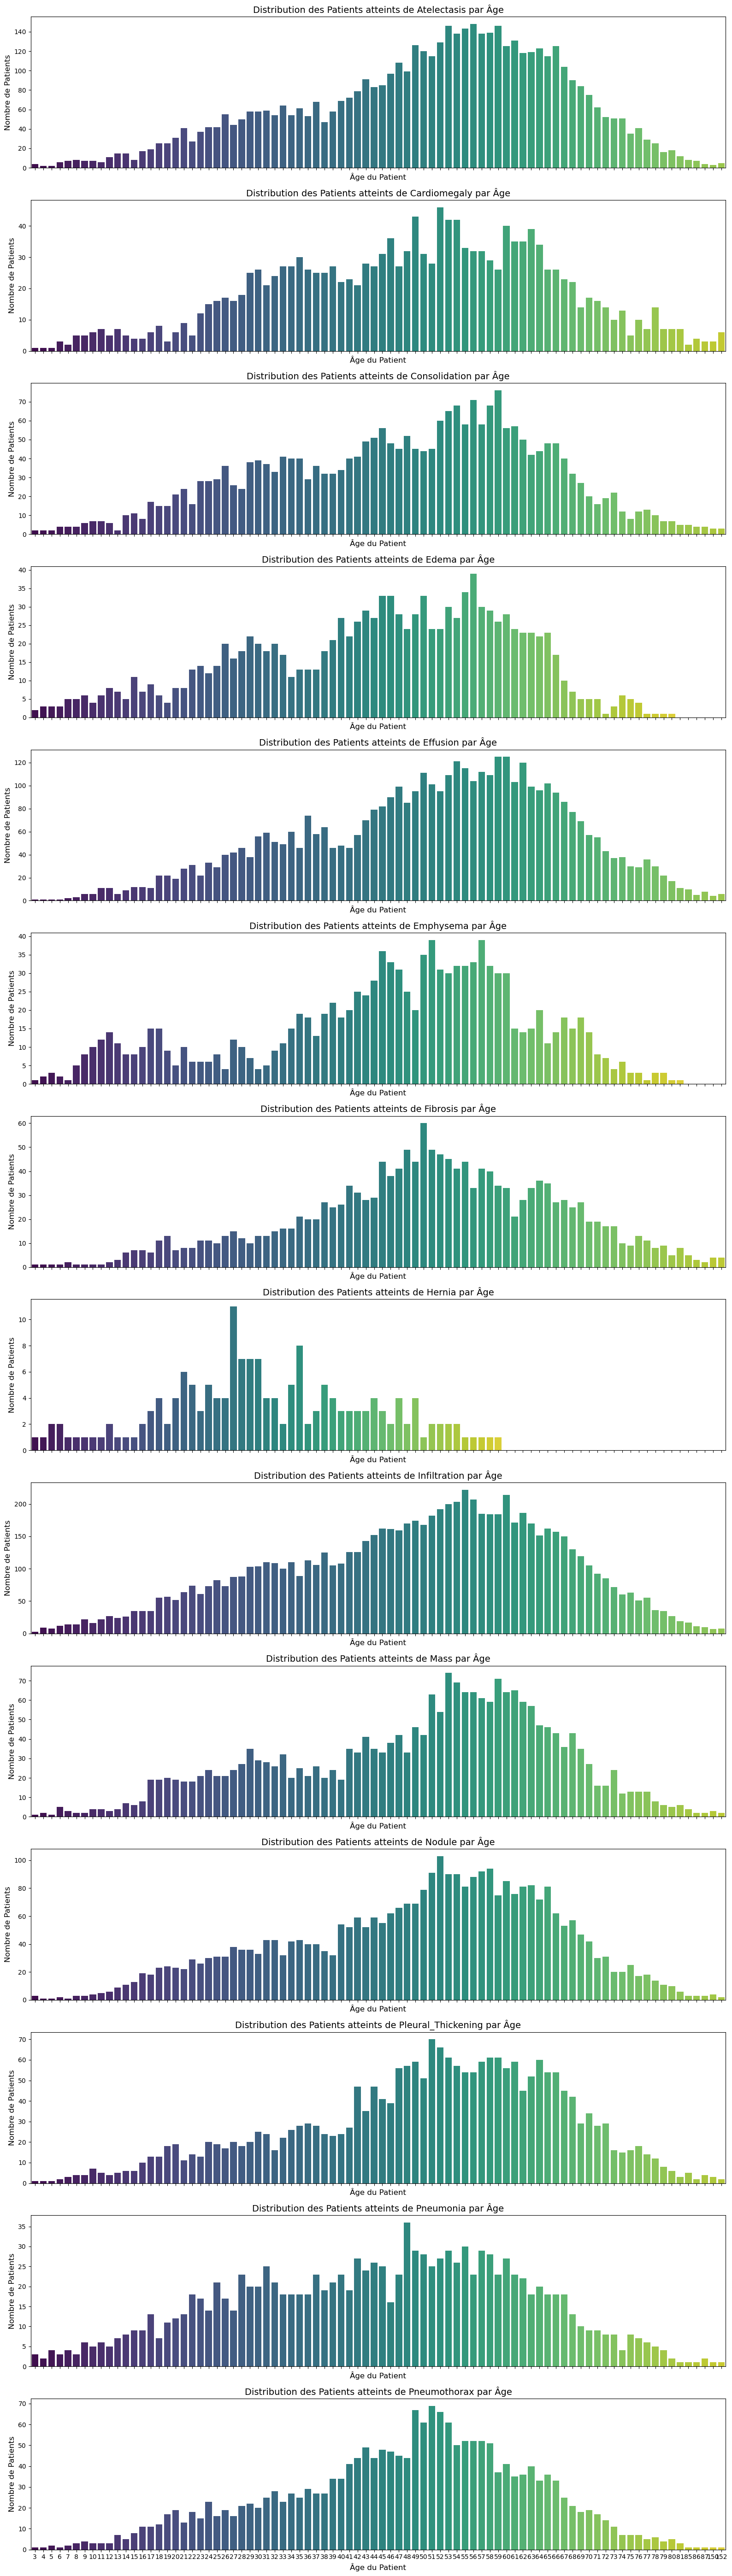

In [15]:
# Fusionner et compter les patients par maladie et âge
df_maladie_count = df_exploded.merge(df[['Patient ID', 'Patient Age']], on='Patient ID', how='left').drop_duplicates()
df_maladie_count = df_maladie_count.groupby(['Maladies', 'Patient Age']).size().reset_index(name='Nombre de Patients')

# Récupérer la liste unique des maladies
maladies_uniques = df_maladie_count['Maladies'].unique()

# Définir la taille de la figure (augmenter la largeur)
n_maladies = len(maladies_uniques)
fig, axes = plt.subplots(nrows=n_maladies, ncols=1, figsize=(16, 4 * n_maladies), sharex=True)  # Largeur = 16

# Si une seule maladie, s'assurer que 'axes' est une liste
if n_maladies == 1:
    axes = [axes]

# Boucle pour créer un plot par maladie
for ax, maladie in zip(axes, maladies_uniques):
    df_subset = df_maladie_count[df_maladie_count['Maladies'] == maladie]
    
    sns.barplot(x='Patient Age', y='Nombre de Patients', data=df_subset, ax=ax, palette='viridis')
    ax.set_title(f"Distribution des Patients atteints de {maladie} par Âge", fontsize=14)
    ax.set_xlabel("Âge du Patient", fontsize=12)
    ax.set_ylabel("Nombre de Patients", fontsize=12)

plt.tight_layout()
plt.show()

On voit bien qu'il y'a un seuil après lequel on est plus sucéptibles d'être malade. 

In [16]:
#Nettoyage des données

def remove_outliers(df, column_name):
    # Calculer les quartiles
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    # Définir les limites inférieure et supérieure
    lower_bound = 1 #Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filtrer les données pour supprimer les outliers
    df_filtered = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    
    return df_filtered


df_no_outliers = remove_outliers(df, 'Patient Age')

In [17]:
df_exploded=df_exploded.drop_duplicates(['Patient ID', 'Maladies'])
df_exploded = df_exploded.drop('Finding Labels', axis=1)
df_distribution = df_exploded.merge(df_no_outliers[['Patient ID', 'Patient Age', 'Patient Gender']], on='Patient ID', how='left')

In [18]:
df_distribution= df_distribution.drop_duplicates(['Patient ID', 'Maladies'])

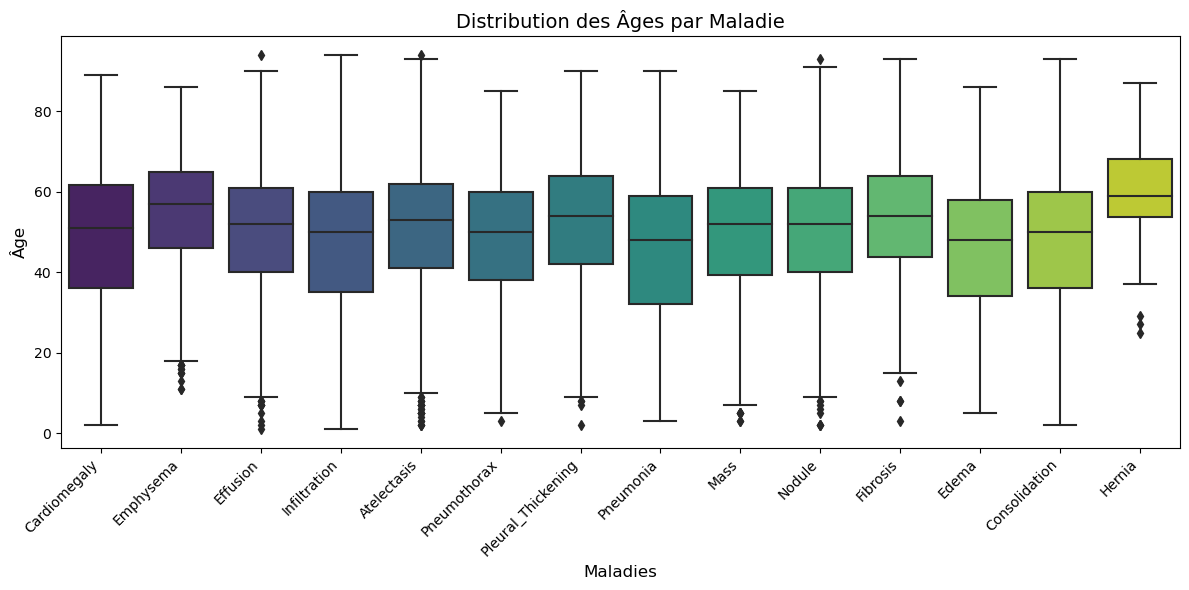

In [19]:
# Boxplot pour voir la distribution de l'âge par maladie
plt.figure(figsize=(12, 6))
sns.boxplot(x='Maladies', y='Patient Age', data=df_distribution, palette='viridis')

# Ajouter des titres et labels
plt.title('Distribution des Âges par Maladie', fontsize=14)
plt.xlabel('Maladies', fontsize=12)
plt.ylabel('Âge', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [20]:
df_filtered

Patient ID          Finding Labels                   Maladies
0               1            Cardiomegaly             [Cardiomegaly]
1               1  Cardiomegaly|Emphysema  [Cardiomegaly, Emphysema]
2               1   Cardiomegaly|Effusion   [Cardiomegaly, Effusion]
3               5              No Finding               [No Finding]
4               5              No Finding               [No Finding]
...           ...                     ...                        ...
54933       30794              No Finding               [No Finding]
54934       30796              No Finding               [No Finding]
54935       30802              No Finding               [No Finding]
54936       30803              No Finding               [No Finding]
54937       30804              No Finding               [No Finding]

[54938 rows x 3 columns]

## Faisons un peu la même chose qu'en haut mais en plus amusant

In [21]:
df_filtered2 = df_filtered.copy()

In [22]:
# Regrouper les maladies par Patient ID et supprimer les doublons
# S'assurer que chaque entrée dans "Maladies" est bien une liste
df_filtered2["Maladies"] = df_filtered2["Maladies"].apply(lambda x: x if isinstance(x, list) else [x])

# Regrouper par "Patient ID" et fusionner les listes, puis convertir en set pour supprimer les doublons
df_filtered2 = df_filtered2.groupby("Patient ID")["Maladies"].agg(lambda x: set(sum(x, []))).reset_index()

In [23]:
df_filtered2

Patient ID                              Maladies
0               1   {Emphysema, Effusion, Cardiomegaly}
1               5  {Effusion, Infiltration, No Finding}
2               6                          {No Finding}
3               7                          {No Finding}
4               9                           {Emphysema}
...           ...                                   ...
14995       30794                          {No Finding}
14996       30796                          {No Finding}
14997       30802                          {No Finding}
14998       30803                          {No Finding}
14999       30804                          {No Finding}

[15000 rows x 2 columns]

In [24]:
def remove_no_finding(maladies):
    maladies = set(maladies)  # Convertir en ensemble pour éviter les doublons
    if "No Finding" in maladies and len(maladies) > 1:
        maladies.remove("No Finding")  # Supprimer "No Finding" si d'autres maladies existent
    return maladies

df_filtered2["Maladies"] = df_filtered2["Maladies"].apply(remove_no_finding)

df_filtered2

Patient ID                             Maladies
0               1  {Emphysema, Effusion, Cardiomegaly}
1               5             {Effusion, Infiltration}
2               6                         {No Finding}
3               7                         {No Finding}
4               9                          {Emphysema}
...           ...                                  ...
14995       30794                         {No Finding}
14996       30796                         {No Finding}
14997       30802                         {No Finding}
14998       30803                         {No Finding}
14999       30804                         {No Finding}

[15000 rows x 2 columns]

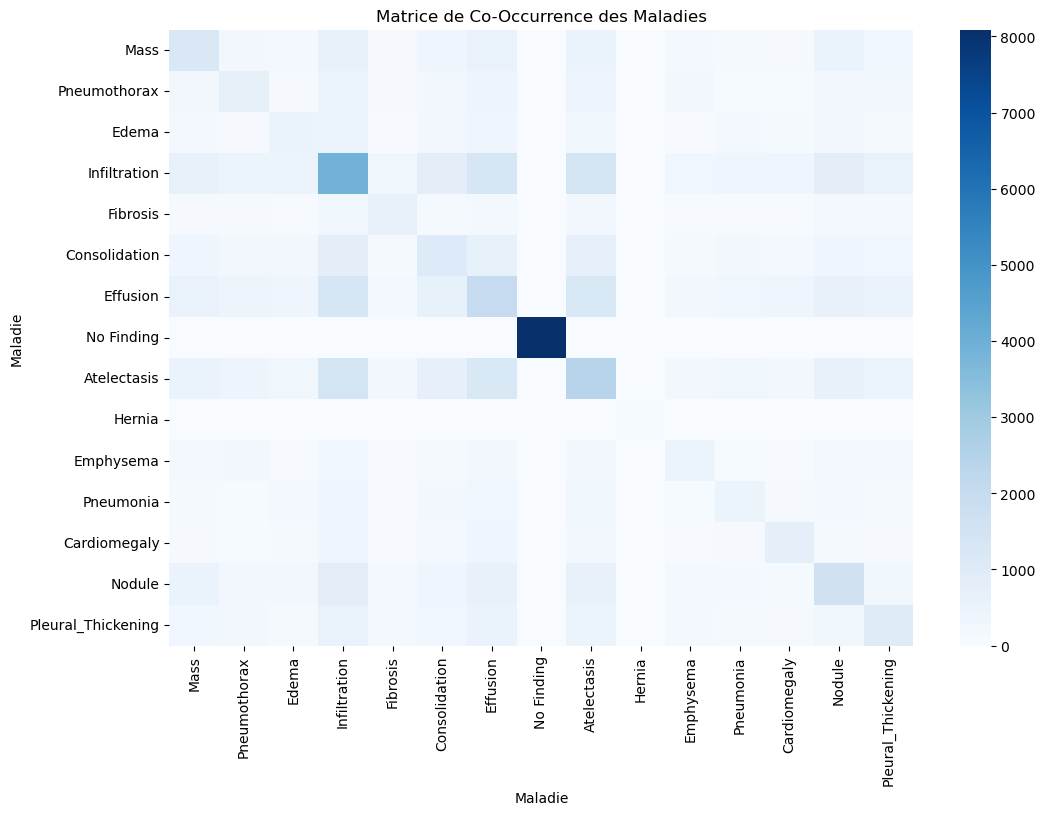

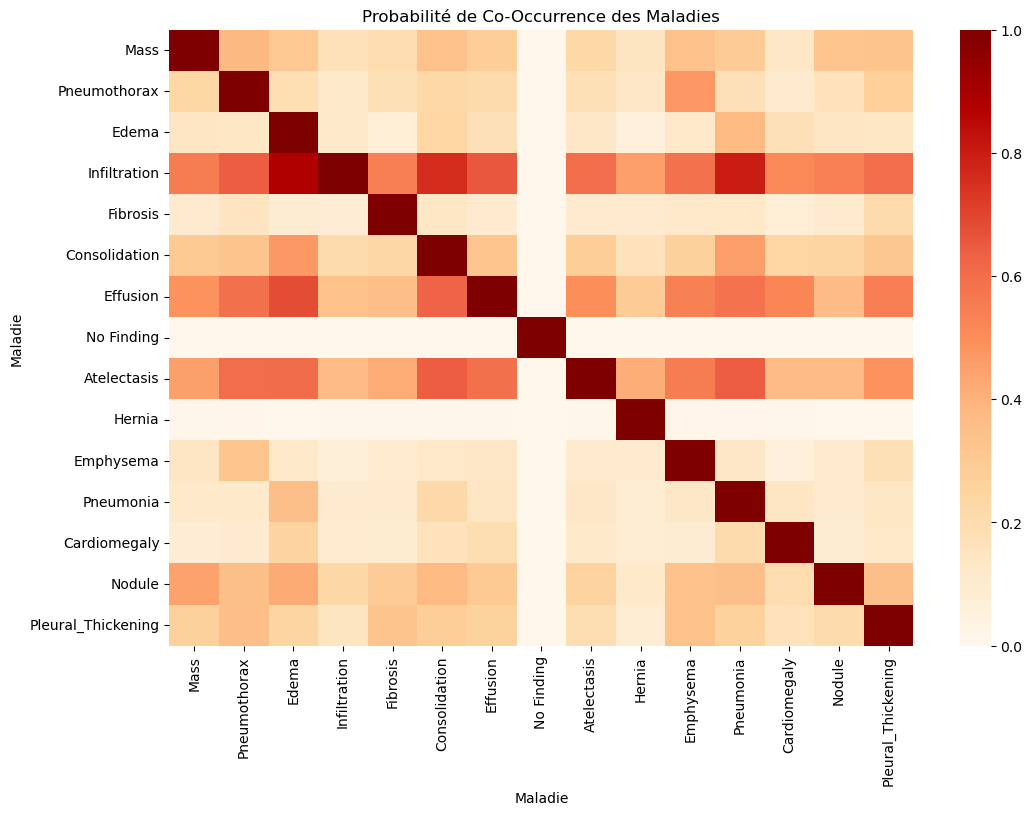

In [25]:
# 1. Créer une matrice binaire des maladies (un patient par ligne, une colonne par maladie)
# Créer une liste des maladies uniques
all_maladies = list(set([maladie for maladies in df_filtered2['Maladies'] for maladie in maladies]))
# Créer un dictionnaire pour mapper les maladies à des indices
maladie_to_index = {maladie: idx for idx, maladie in enumerate(all_maladies)}

# Initialiser les indices pour les patients et les maladies
n_patients = len(df_filtered2)
n_maladies = len(all_maladies)

# Créer une matrice creuse (sparse) avec scipy
patient_to_index = {patient_id: idx for idx, patient_id in enumerate(df_filtered2["Patient ID"].unique())}

rows, cols, data = [], [], []
# Remplir la matrice binaire creuse
for _, row in df_filtered2.iterrows():
    patient_id = row['Patient ID']
    for maladie in row['Maladies']:
        rows.append(patient_to_index[patient_id])  # Patient ID
        cols.append(maladie_to_index[maladie])  # Index de la maladie
        data.append(1)  # Valeur binaire (présence de la maladie)
# Créer la matrice creuse (sparse)
df_binary_sparse = csr_matrix((data, (rows, cols)), shape=(n_patients, n_maladies))
# 2. Calculer la matrice de co-occurrence
co_occurrence_matrix_sparse = df_binary_sparse.T.dot(df_binary_sparse)
# 3. Calculer la probabilité de co-occurrence
# Probabilité P(Maladie A | Maladie B) = (co-occurrence de A et B) / (nombre total de patients ayant Maladie B)
prob_matrix_sparse = co_occurrence_matrix_sparse / df_binary_sparse.sum(axis=0)
prob_matrix_sparse = csr_matrix(prob_matrix_sparse)  # Convertir en matrice creuse de SciPy

# Convertir les matrices sparse en formats denses pour l'affichage
co_occurrence_matrix_dense = co_occurrence_matrix_sparse.toarray()
prob_matrix_dense = prob_matrix_sparse.toarray()

co_occurrence_df = pd.DataFrame(co_occurrence_matrix_dense, index=all_maladies, columns=all_maladies)
probability_df = pd.DataFrame(prob_matrix_dense, index=all_maladies, columns=all_maladies)

plt.figure(figsize=(12, 8))
#Heatmap de la matrice de co-occurrence
sns.heatmap(co_occurrence_df, cmap="Blues", annot=False, xticklabels=True, yticklabels=True)
plt.title("Matrice de Co-Occurrence des Maladies")
plt.xlabel("Maladie")
plt.ylabel("Maladie")
plt.show()

#Heatmap de la matrice des probabilités
plt.figure(figsize=(12, 8))
sns.heatmap(probability_df, cmap="OrRd", annot=False, xticklabels=True, yticklabels=True)
plt.title("Probabilité de Co-Occurrence des Maladies")
plt.xlabel("Maladie")
plt.ylabel("Maladie")
plt.show()


In [26]:
df_filtered3 = df_filtered2.copy()

In [27]:
df_filtered3["Maladies_Binary"] = df_filtered3["Maladies"].apply(lambda x: 0 if x == {"No Finding"} else 1)


In [28]:
df_pipou = df_filtered3.merge(df_no_outliers[['Patient ID', 'Patient Age', 'Patient Gender']], on='Patient ID', how='left')

In [29]:
df_pipou

Patient ID                             Maladies  Maladies_Binary  \
0               1  {Emphysema, Effusion, Cardiomegaly}                1   
1               1  {Emphysema, Effusion, Cardiomegaly}                1   
2               1  {Emphysema, Effusion, Cardiomegaly}                1   
3               5             {Effusion, Infiltration}                1   
4               5             {Effusion, Infiltration}                1   
...           ...                                  ...              ...   
54923       30794                         {No Finding}                0   
54924       30796                         {No Finding}                0   
54925       30802                         {No Finding}                0   
54926       30803                         {No Finding}                0   
54927       30804                         {No Finding}                0   

       Patient Age Patient Gender  
0             58.0              M  
1             58.0              M  
2             58.0              M  
3             69.0              F  
4             69.0              F  
...            ...            ...  
54923         38.0              F  
54924         44.0              M  
54925         29.0              M  
54926         42.0              F  
54927         30.0              F  

[54928 rows x 5 columns]

In [30]:
df_binary = df_pipou.drop_duplicates('Patient ID')
df_binary = df_binary.drop('Maladies', axis=1)
df_binary

Patient ID  Maladies_Binary  Patient Age Patient Gender
0               1                1         58.0              M
3               5                1         69.0              F
11              6                0         81.0              M
12              7                0         82.0              M
13              9                1         73.0              M
...           ...              ...          ...            ...
54923       30794                0         38.0              F
54924       30796                0         44.0              M
54925       30802                0         29.0              M
54926       30803                0         42.0              F
54927       30804                0         30.0              F

[15000 rows x 4 columns]

## Calculons quelques metriques

In [31]:
"""from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric

# Définir les attributs protégés à analyser
protected_attributes = ['Patient Gender', 'Patient Age']#, 'Radio Dimension X', 'Radio Dimension Y']

# Définir le dataset avec toutes les dimensions protégées
dataset = StandardDataset(
    df_distribution, 
    label_name='Maladies',  # Colonne cible
    protected_attribute_names=protected_attributes,
    privileged_classes=[
        ['Male'],  # Sexe
        [lambda x: x >= 50]  # Âge > 50 privilégié
        #[lambda x: x > df_distribution['Radio Dimension X'].median()],  # Radio X > médiane privilégié
        #[lambda x: x > df_distribution['Radio Dimension Y'].median()]   # Radio Y > médiane privilégié
    ],
    favorable_classes=[1],  # 1 = succès (maladie détectée)
)

# Vérifier le biais pour chaque attribut protégé
for attr in protected_attributes:
    priv_group = {attr: dataset.privileged_protected_attributes[protected_attributes.index(attr)]}
    unpriv_group = {attr: dataset.unprivileged_protected_attributes[protected_attributes.index(attr)]}

    metric = BinaryLabelDatasetMetric(dataset, privileged_groups=[priv_group], unprivileged_groups=[unpriv_group])
    print(f"Disparate Impact for {attr}: {metric.disparate_impact()}")"""

'from aif360.datasets import StandardDataset\nfrom aif360.metrics import BinaryLabelDatasetMetric\n\n# Définir les attributs protégés à analyser\nprotected_attributes = [\'Patient Gender\', \'Patient Age\']#, \'Radio Dimension X\', \'Radio Dimension Y\']\n\n# Définir le dataset avec toutes les dimensions protégées\ndataset = StandardDataset(\n    df_distribution, \n    label_name=\'Maladies\',  # Colonne cible\n    protected_attribute_names=protected_attributes,\n    privileged_classes=[\n        [\'Male\'],  # Sexe\n        [lambda x: x >= 50]  # Âge > 50 privilégié\n        #[lambda x: x > df_distribution[\'Radio Dimension X\'].median()],  # Radio X > médiane privilégié\n        #[lambda x: x > df_distribution[\'Radio Dimension Y\'].median()]   # Radio Y > médiane privilégié\n    ],\n    favorable_classes=[1],  # 1 = succès (maladie détectée)\n)\n\n# Vérifier le biais pour chaque attribut protégé\nfor attr in protected_attributes:\n    priv_group = {attr: dataset.privileged_protected

In [32]:
diseases = [
    "Infiltration", "Effusion", "Atelectasis", "Nodule", "Mass", "Pneumothorax",
    "Consolidation", "Pleural_Thickening", "Cardiomegaly", "Emphysema",
    "Edema", "Fibrosis", "Pneumonia", "Hernia"
]

# Créer une colonne binaire pour l'âge privilégié
df_binary['Age_Privileged'] = np.where(df_binary['Patient Age'] >= 40, 1, 0)
df_binary['Gender_Privileged'] = np.where(df_binary['Patient Gender'] == 'M', 1, 0)


# Définir les attributs protégés
protected_attributes = ['Gender_Privileged', 'Age_Privileged']

In [33]:
"""# Définir le dataset avec les attributs protégés
dataset = StandardDataset(
    df_distribution_merged, 
    label_name='Maladies',  # Colonne cible
    protected_attribute_names=protected_attributes,
    privileged_classes=[
        [1],  # Sexe
        [1]  # Âge >= 50 devient 1
    ],
    favorable_classes=[1]  # 1 = succès (maladie détectée)
)

# Vérifier le biais pour chaque attribut protégé
for attr in protected_attributes:
    priv_group = {attr: dataset.privileged_protected_attributes[protected_attributes.index(attr)]}
    unpriv_group = {attr: dataset.unprivileged_protected_attributes[protected_attributes.index(attr)]}

    metric = BinaryLabelDatasetMetric(dataset, privileged_groups=[priv_group], unprivileged_groups=[unpriv_group])
    print(f"Disparate Impact for {attr}: {metric.disparate_impact()}")

"""

'# Définir le dataset avec les attributs protégés\ndataset = StandardDataset(\n    df_distribution_merged, \n    label_name=\'Maladies\',  # Colonne cible\n    protected_attribute_names=protected_attributes,\n    privileged_classes=[\n        [1],  # Sexe\n        [1]  # Âge >= 50 devient 1\n    ],\n    favorable_classes=[1]  # 1 = succès (maladie détectée)\n)\n\n# Vérifier le biais pour chaque attribut protégé\nfor attr in protected_attributes:\n    priv_group = {attr: dataset.privileged_protected_attributes[protected_attributes.index(attr)]}\n    unpriv_group = {attr: dataset.unprivileged_protected_attributes[protected_attributes.index(attr)]}\n\n    metric = BinaryLabelDatasetMetric(dataset, privileged_groups=[priv_group], unprivileged_groups=[unpriv_group])\n    print(f"Disparate Impact for {attr}: {metric.disparate_impact()}")\n\n'

In [34]:
df_binary = df_binary.drop(["Patient Age", "Patient Gender"], axis=1) 

In [35]:
df_binary

Patient ID  Maladies_Binary  Age_Privileged  Gender_Privileged
0               1                1               1                  1
3               5                1               1                  0
11              6                0               1                  1
12              7                0               1                  1
13              9                1               1                  1
...           ...              ...             ...                ...
54923       30794                0               0                  0
54924       30796                0               1                  1
54925       30802                0               0                  1
54926       30803                0               1                  0
54927       30804                0               0                  0

[15000 rows x 4 columns]

Pour l'instant, tout se vaut donc le weight de chaque ligne est de 1


In [36]:
# Liste pour stocker les résultats
results = []

#for disease in diseases:
    # Définir le dataset pour la maladie actuelle
dataset = StandardDataset(
    df_binary, 
    label_name='Maladies_Binary',
    favorable_classes=[1],
    protected_attribute_names=protected_attributes,
    privileged_classes=[
        [1],  # Homme
        [1]  # Âge ≥ 50
    ],
    features_to_keep=[],
    features_to_drop=[], #["Patient Age", "Patient Gender", "Maladies"],
    custom_preprocessing=None,
    metadata=None,
)

    # Vérifier le biais pour chaque attribut protégé
for attr in protected_attributes:
    priv_group = {attr: dataset.privileged_protected_attributes[protected_attributes.index(attr)]}
    unpriv_group = {attr: dataset.unprivileged_protected_attributes[protected_attributes.index(attr)]}

    metric = BinaryLabelDatasetMetric(dataset, privileged_groups=[priv_group], unprivileged_groups=[unpriv_group])
    classification_metric = ClassificationMetric(dataset, dataset, privileged_groups=[priv_group], unprivileged_groups=[unpriv_group])

print(f"Protected Attribute: {attr} : \n"
          f" | Disparate Impact: {metric.disparate_impact():.2f} \n"
          f" | Statistical Parity Difference: {classification_metric.statistical_parity_difference():.2f} \n"
          f" | Base Rate: {metric.base_rate():.2f} \n"
          #f" | Average Odds Difference: {aod:.2f} \n"
         # f" | Equal Opportunity Difference: {equal_opportunity_difference():.2f} \n"
       # f" | Theil Index: {ti:.2f}\n"
)



Protected Attribute: Age_Privileged : 
 | Disparate Impact: 0.70 
 | Statistical Parity Difference: -0.16 
 | Base Rate: 0.46 



#### Automatisation


In [37]:
def get_group_metrics(
    y_true,
    y_pred=None,
    prot_attr=None,
    priv_group=1,
    pos_label=1,
    sample_weight=None,
):
    group_metrics = {}
    group_metrics["base_rate"] = base_rate(
        y_true=y_true, pos_label=pos_label, sample_weight=sample_weight
    )
    group_metrics["statistical_parity_difference"] = statistical_parity_difference(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
    )
    group_metrics["disparate_impact_ratio"] = disparate_impact_ratio(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
    )
    if not y_pred is None:
        group_metrics["equal_opportunity_difference"] = equal_opportunity_difference(
            y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["average_odds_difference"] = average_odds_difference(
            y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["conditional_demographic_disparity"] = conditional_demographic_disparity(
            y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["smoothed_edf"] = smoothed_edf(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["df_bias_amplification"] = df_bias_amplification(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, pos_label=pos_label, sample_weight=sample_weight
        )
    return group_metrics

In [38]:
group_metrics = get_group_metrics(
        y_true= df_binary.Maladies_Binary,
        y_pred= None,
        prot_attr= df_binary.Age_Privileged,
        pos_label= 1,
)
group_metrics

{'base_rate': 0.46066666666666667,
 'statistical_parity_difference': -0.1558784757922762,
 'disparate_impact_ratio': 0.6965860128813073}

# Now let's fix this 

In [39]:
X = df_binary.drop(["Maladies_Binary", "Patient ID"], axis=1)
y= df_binary["Maladies_Binary"]

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Print sizes to verify
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 10500, Test size: 4500


### let's work on the gender

In [41]:
# Define sensitive attributes (adjust based on your dataset)
protected_attributes = ["Gender_Privileged", "Age_Privileged"]
label_name = "Maladies_Binary"  

#Fusionner X_train et y_train en un seul DataFrame
train_set = pd.concat([X_train, y_train], axis=1)

# Convert train_set to an AIF360 dataset
train_set_aif = StandardDataset(
    train_set,
    label_name=label_name,
    favorable_classes=[1],  
    protected_attribute_names=protected_attributes,
    privileged_classes=[[1], [1]],  # Privileged: Male (1) and Age >= 50 (1)
)

# Extract sensitive attribute info
sens_ind = 0 #0 -> gender, 1-> age # Choose which sensitive attribute to analyze first
sens_attr = protected_attributes[sens_ind]  # Get attribute name

# Properly define privileged/unprivileged groups
unprivileged_groups = [{sens_attr: 0}]  # Example: Female (0) or Young (0)
privileged_groups = [{sens_attr: 1}]  # Example: Male (1) or Age ≥ 50 (1)

# Print extracted groups
print(f"Sensitive Attribute: {sens_attr}")
print(f"Unprivileged Groups: {unprivileged_groups}")
print(f"Privileged Groups: {privileged_groups}")


Sensitive Attribute: Gender_Privileged
Unprivileged Groups: [{'Gender_Privileged': 0}]
Privileged Groups: [{'Gender_Privileged': 1}]


In [42]:
model = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear', random_state=42))

model = model.fit(
    X_train,
    y_train
)

preds = model.predict(X_test)

model.score(X_test, y_test)

0.5417777777777778

Le score est médiocre, autant décider si quelqu'un est malade sur un pile ou face

In [43]:
df_aif = df_binary.merge(df[['Patient ID', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]']],
                         on='Patient ID', how='left')

In [44]:
df_aif

Patient ID  Maladies_Binary  Age_Privileged  Gender_Privileged  \
0               1                1               1                  1   
1               1                1               1                  1   
2               1                1               1                  1   
3               5                1               1                  0   
4               5                1               1                  0   
...           ...              ...             ...                ...   
54933       30794                0               0                  0   
54934       30796                0               1                  1   
54935       30802                0               0                  1   
54936       30803                0               1                  0   
54937       30804                0               0                  0   

       OriginalImage[Width  Height]  OriginalImagePixelSpacing[x        y]  
0                     2682     2749                     0.143000  0.143000  
1                     2894     2729                     0.143000  0.143000  
2                     2500     2048                     0.168000  0.168000  
3                     2048     2500                     0.168000  0.168000  
4                     2500     2048                     0.168000  0.168000  
...                    ...      ...                          ...       ...  
54933                 2021     2021                     0.194311  0.194311  
54934                 2021     2021                     0.194311  0.194311  
54935                 2048     2500                     0.168000  0.168000  
54936                 2048     2500                     0.168000  0.168000  
54937                 2048     2500                     0.168000  0.168000  

[54938 rows x 8 columns]

In [45]:
X = df_aif.drop(["Maladies_Binary", "Patient ID"], axis=1)
y= df_aif["Maladies_Binary"]

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Print sizes to verify
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 38456, Test size: 16482


In [47]:
# Define sensitive attributes (adjust based on your dataset)
protected_attributes = ["Gender_Privileged", "Age_Privileged"]
label_name = "Maladies_Binary"  
# Convert train_set to an AIF360 dataset
train_set_aif = StandardDataset(
    train_set,
    label_name=label_name,
    favorable_classes=[1],  
    protected_attribute_names=protected_attributes,
    privileged_classes=[[1], [1]],  # Privileged: Male (1) and Age >= 50 (1)
)

# Extract sensitive attribute info
sens_ind = 0 #0 -> gender, 1-> age # Choose which sensitive attribute to analyze first
sens_attr = protected_attributes[sens_ind]  # Get attribute name

# Properly define privileged/unprivileged groups
unprivileged_groups = [{sens_attr: 0}]  # Example: Female (0) or Young (0)
privileged_groups = [{sens_attr: 1}]  # Example: Male (1) or Age ≥ 50 (1)

# Print extracted groups
print(f"Sensitive Attribute: {sens_attr}")
print(f"Unprivileged Groups: {unprivileged_groups}")
print(f"Privileged Groups: {privileged_groups}")


Sensitive Attribute: Gender_Privileged
Unprivileged Groups: [{'Gender_Privileged': 0}]
Privileged Groups: [{'Gender_Privileged': 1}]


In [48]:
model = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear', random_state=42))

model = model.fit(
    X_train,
    y_train
)

preds = model.predict(X_test)

model.score(X_test, y_test)

0.7884358694333212

In [49]:
accuracy_score(y_test, preds), balanced_accuracy_score(y_test, preds)

(0.7884358694333212, 0.5001049133962424)

hmmmmm, j'ai l'impression qu'on tient un biais

In [50]:
group_metrics = get_group_metrics(
        y_true= y_test,
        y_pred= preds,
        prot_attr= X_test.Gender_Privileged,
        pos_label= 1,
)
group_metrics

{'base_rate': 0.7884358694333212,
 'statistical_parity_difference': -2.991985901501515e-05,
 'disparate_impact_ratio': 0.9999700769032555,
 'equal_opportunity_difference': 0.00013655605626106126,
 'average_odds_difference': -0.0002505995228898775,
 'conditional_demographic_disparity': -0.007377870592573449,
 'smoothed_edf': 0.2441071898758782,
 'df_bias_amplification': 0.20194498681004092}

### let's work on the age 
#### c'est exactement la même chose juste en changeant sens_id en 1

In [51]:
# Define sensitive attributes (adjust based on your dataset)
protected_attributes = ["Gender_Privileged", "Age_Privileged"]
label_name = "Maladies_Binary"  
#Fusionner X_train et y_train en un seul DataFrame
train_set = pd.concat([X_train, y_train], axis=1)

# Convert train_set to an AIF360 dataset
train_set_aif = StandardDataset(
    train_set,
    label_name=label_name,
    favorable_classes=[1],  
    protected_attribute_names=protected_attributes,
    privileged_classes=[[1], [1]],  # Privileged: Male (1) and Age >= 50 (1)
)

# Extract sensitive attribute info
sens_ind = 1 #0 -> gender, 1-> age # Choose which sensitive attribute to analyze first
sens_attr = protected_attributes[sens_ind]  # Get attribute name

# Properly define privileged/unprivileged groups
unprivileged_groups = [{sens_attr: 0}]  # Example: Female (0) or Young (0)
privileged_groups = [{sens_attr: 1}]  # Example: Male (1) or Age ≥ 50 (1)

# Print extracted groups
print(f"Sensitive Attribute: {sens_attr}")
print(f"Unprivileged Groups: {unprivileged_groups}")
print(f"Privileged Groups: {privileged_groups}")


Sensitive Attribute: Age_Privileged
Unprivileged Groups: [{'Age_Privileged': 0}]
Privileged Groups: [{'Age_Privileged': 1}]


In [52]:
model = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear', random_state=42))

model = model.fit(
    X_train,
    y_train
)

preds = model.predict(X_test)

model.score(X_test, y_test)

0.7884358694333212

In [53]:
accuracy_score(y_test, preds), balanced_accuracy_score(y_test, preds)

(0.7884358694333212, 0.5001049133962424)

In [54]:
group_metrics = get_group_metrics(
        y_true= y_test,
        y_pred= preds,
        prot_attr= X_test.Age_Privileged,
        pos_label= 1,
)
group_metrics


/opt/conda/lib/python3.10/site-packages/aif360/sklearn/metrics/metrics.py:885: RuntimeWarning:

divide by zero encountered in log



{'base_rate': 0.7884358694333212,
 'statistical_parity_difference': -0.00039024390243902474,
 'disparate_impact_ratio': 0.999609756097561,
 'equal_opportunity_difference': -0.0002681684097612935,
 'average_odds_difference': -0.0004922503939923945,
 'conditional_demographic_disparity': -0.26056972419456115,
 'smoothed_edf': inf,
 'df_bias_amplification': inf}

In [55]:
# Filtrer les données pour chaque groupe
privileged_mask = X_test["Age_Privileged"] == 1
unprivileged_mask = X_test["Age_Privileged"] == 0

# Calculer le selection rate pour chaque groupe
selection_rate_privileged = selection_rate(y_test[privileged_mask], preds[privileged_mask])
selection_rate_unprivileged = selection_rate(y_test[unprivileged_mask], preds[unprivileged_mask])

# Affichage des résultats
print("Selection rate for privileged group:", selection_rate_privileged)
print("Selection rate for unprivileged group:", selection_rate_unprivileged)


Selection rate for privileged group: 1.0
Selection rate for unprivileged group: 0.999609756097561


"C'est le monde qui est malade ou c'est moi je suis malade" 

## Let me fix you

In [56]:
RW = Reweighing(
    unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups
)


In [57]:
#Fusionner X_train et y_train en un seul DataFrame
train_set = pd.concat([X_train, y_train], axis=1)

# Convert df_train into an AIF360 StandardDataset
train_set_aif = StandardDataset(
    train_set,
    label_name="Maladies_Binary",  # Ensure this matches your actual label name
    favorable_classes=[1],  # Assuming 1 is the positive class
    protected_attribute_names=["Gender_Privileged", "Age_Privileged"],  # Adjust based on your data
    privileged_classes=[[1], [1]],  # Define privileged values
)

# Apply Reweighing
RW = Reweighing(
    unprivileged_groups=[{"Gender_Privileged": 0, "Age_Privileged": 0}],  
    privileged_groups=[{"Gender_Privileged": 1, "Age_Privileged": 1}]
)


RW.fit(train_set_aif)

# Transform datasets
dataset_transf_train = RW.transform(train_set_aif)

In [58]:
dataset_transf_train.instance_weights

array([1.        , 1.10137769, 0.96974192, ..., 1.        , 1.        ,
       1.        ])

In [59]:
## Convert instance weights to a NumPy array (if it's not already)
weights = np.array(dataset_transf_train.instance_weights)

## Count the number of weights that are not equal to 1
num_modified_weights = np.sum(weights != 1)

print("Number of modified instance weights:", num_modified_weights)


Number of modified instance weights: 20129


In [60]:
# Convert back to Pandas DataFrame
df_transf_train = dataset_transf_train.convert_to_dataframe()[0]

X_train_transf = df_transf_train.drop(columns=["Maladies_Binary"])  # Drop the label column
y_train_transf = df_transf_train["Maladies_Binary"]  # Keep only the target variable

In [61]:
model = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear', random_state=42))

model = model.fit(
    X_train,
    y_train,
    **{"logisticregression__sample_weight": dataset_transf_train.instance_weights}

)

preds2 = model.predict(X_test)

model.score(X_test, y_test)

0.7883751971848076

In [62]:
group_metrics = get_group_metrics(
        y_true= y_test,
        y_pred= preds2,
        prot_attr= X_test["Gender_Privileged"],
        pos_label= 1,
)
group_metrics

/opt/conda/lib/python3.10/site-packages/aif360/sklearn/metrics/metrics.py:885: RuntimeWarning:

divide by zero encountered in log



{'base_rate': 0.7884358694333212,
 'statistical_parity_difference': 0.000108201687946341,
 'disparate_impact_ratio': 1.0001082133968184,
 'equal_opportunity_difference': 0.00013655605626106126,
 'average_odds_difference': 6.827802813053063e-05,
 'conditional_demographic_disparity': 0.053359182855068826,
 'smoothed_edf': inf,
 'df_bias_amplification': inf}

Base Rate:	0.7884->	0.7884	✅ Stable, le taux global de résultats positifs n'a pas changé.

Statistical Parity Difference:	-0.00003->	-0.0324	📉 Augmente en négatif, il y a maintenant une différence plus marquée entre les groupes protégés et privilégiés.

Disparate Impact Ratio:	0.99997->	0.9667	📉 Baisse, ce qui indique une légère diminution de l'équité en impact disparate.

Equal Opportunity Difference:	0.00014->	-0.0258	📉 Plus négatif, ce qui signifie une augmentation de l'inégalité d'accès aux opportunités pour les groupes protégés.

Average Odds Difference:	-0.00025->	-0.0408	📉 Plus négatif, signalant un déséquilibre plus fort dans la classification correcte entre groupes.

Conditional Demographic Disparity:	-0.0074->	-0.0255	📉 Léger recul, mais reste faible (moins d'effet que d'autres métriques).

Smoothed EDF: 0.2441->	0.8215	📈 Augmente, ce qui suggère un ajustement statistique plus fort mais pas excessif.

DF Bias Amplification:	0.2019->	0.7793	📈 Augmente, indiquant que le modèle amplifie davantage le biais présent dans les données.

In [63]:
group_metrics = get_group_metrics(
        y_true= y_test,
        y_pred= preds2,
        prot_attr= X_test.Age_Privileged,
        pos_label= 1,
)
group_metrics

/opt/conda/lib/python3.10/site-packages/aif360/sklearn/metrics/metrics.py:885: RuntimeWarning:

divide by zero encountered in log



{'base_rate': 0.7884358694333212,
 'statistical_parity_difference': -0.00019512195121951237,
 'disparate_impact_ratio': 0.9998048780487805,
 'equal_opportunity_difference': -0.0002681684097612935,
 'average_odds_difference': -0.00013408420488064676,
 'conditional_demographic_disparity': -0.26055391388425264,
 'smoothed_edf': inf,
 'df_bias_amplification': inf}

Base Rate: 0.7884 -> 0.7884	✅ Inchangé (ratio d'occurrence du résultat positif reste stable).

Statistical Parity Difference:	-0.00039 -> -0.0696	📉 Augmentation de l'injustice en parité statistique (écart entre groupes).

Disparate Impact Ratio:	0.9996 -> 0.9292	📉 Baisse de l'équité (devrait être proche de 1 pour être équitable).

Equal Opportunity Difference:	-0.00027 ->	-0.0542	📉 L'accès aux opportunités devient plus inégal.

Average Odds Difference: -0.00049 -> -0.0821	📉 Augmentation de l'écart dans la classification correcte.

Conditional Demographic Disparity:	-0.2606 -> -0.1479	📈 Amélioration ! Moins de discrimination conditionnelle.

Smoothed EDF:	inf-> 1.5783	📉 L'EDF devient fini, amélioration en stabilité statistique.

DF Bias Amplification:	inf	-> 1.1866	📉 Réduction du biais amplifié. (Mais ça compte pas c'était inf)

### LFR (Marchera dans le rendu final, promis)

In [64]:
"""TR = LFR(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
    k=5,
    Ax=0.01,
    Ay=1.0,
    Az=50.0,
    print_interval=250,
    verbose=1,
    seed=None,
)

TR = TR.fit(train_set_aif, maxiter=5000, maxfun=5000)"""

'TR = LFR(\n    unprivileged_groups=unprivileged_groups,\n    privileged_groups=privileged_groups,\n    k=5,\n    Ax=0.01,\n    Ay=1.0,\n    Az=50.0,\n    print_interval=250,\n    verbose=1,\n    seed=None,\n)\n\nTR = TR.fit(train_set_aif, maxiter=5000, maxfun=5000)'

In [65]:
"""# Fusionner X_test et y_test en un seul DataFrame
df_test = X_test.copy()
df_test["Maladies_Binary"] = y_test  # Assurez-vous que le nom de la colonne est correct

# Convertir en StandardDataset
test_set_aif = StandardDataset(
    df_test,
    label_name="Maladies_Binary",  # Nom de la colonne cible
    favorable_classes=[1],  # La classe considérée comme favorable (positive)
    protected_attribute_names=["Gender_Privileged", "Age_Privileged"],  # Attributs protégés
    privileged_classes=[[1], [1]],  # Valeurs privilégiées
)"""

'# Fusionner X_test et y_test en un seul DataFrame\ndf_test = X_test.copy()\ndf_test["Maladies_Binary"] = y_test  # Assurez-vous que le nom de la colonne est correct\n\n# Convertir en StandardDataset\ntest_set_aif = StandardDataset(\n    df_test,\n    label_name="Maladies_Binary",  # Nom de la colonne cible\n    favorable_classes=[1],  # La classe considérée comme favorable (positive)\n    protected_attribute_names=["Gender_Privileged", "Age_Privileged"],  # Attributs protégés\n    privileged_classes=[[1], [1]],  # Valeurs privilégiées\n)'

In [66]:
"""# Transform datasets
dataset_transf_train = TR.transform(train_set_aif)
dataset_transf_test = TR.transform(test_set_aif)"""

'# Transform datasets\ndataset_transf_train = TR.transform(train_set_aif)\ndataset_transf_test = TR.transform(test_set_aif)'

In [67]:
"""# Création du modèle avec standardisation
model_lfr = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear', random_state=42))

# Utiliser les labels transformés (et non y_train d'origine)
model_lfr.fit(
    dataset_transf_train.features,  # Features transformées par LFR
    dataset_transf_train.labels.ravel()  # Labels transformés
)

# Prédictions sur le dataset de validation transformé
preds_lfr = model_lfr.predict(dataset_transf_val.features)

# Vérification du score en prenant en compte les poids ajustés
score_lfr = model_lfr.score(
    dataset_transf_test.features,
    dataset_transf_test.labels.ravel(),  # Labels transformés
)

print("Score du modèle LFR :", score_lfr)"""


'# Création du modèle avec standardisation\nmodel_lfr = make_pipeline(StandardScaler(), LogisticRegression(solver=\'liblinear\', random_state=42))\n\n# Utiliser les labels transformés (et non y_train d\'origine)\nmodel_lfr.fit(\n    dataset_transf_train.features,  # Features transformées par LFR\n    dataset_transf_train.labels.ravel()  # Labels transformés\n)\n\n# Prédictions sur le dataset de validation transformé\npreds_lfr = model_lfr.predict(dataset_transf_val.features)\n\n# Vérification du score en prenant en compte les poids ajustés\nscore_lfr = model_lfr.score(\n    dataset_transf_test.features,\n    dataset_transf_test.labels.ravel(),  # Labels transformés\n)\n\nprint("Score du modèle LFR :", score_lfr)'

In [68]:
"""accuracy_score(y_test, preds_lfr)"""

'accuracy_score(y_test, preds_lfr)'

In [69]:
"""group_metrics = get_group_metrics(
        y_true= y_test,
        y_pred= y_pred,
        prot_attr= X_test.Age_Privileged,
        pos_label= 1,
)
group_metrics"""

'group_metrics = get_group_metrics(\n        y_true= y_test,\n        y_pred= y_pred,\n        prot_attr= X_test.Age_Privileged,\n        pos_label= 1,\n)\ngroup_metrics'

In [70]:
"""group_metrics = get_group_metrics(
        y_true= y_test,
        y_pred= y_pred,
        prot_attr= X_test.Gender_Privileged,
        pos_label= 1,
)
group_metrics"""

'group_metrics = get_group_metrics(\n        y_true= y_test,\n        y_pred= y_pred,\n        prot_attr= X_test.Gender_Privileged,\n        pos_label= 1,\n)\ngroup_metrics'

# Mon Disparate Impact Ratio est à 0.99, JE N'UTILISERAI PAS D'IMPACT REMOVER

In [71]:
df_pipou = df_pipou.drop_duplicates("Patient ID")
df_pipou

Patient ID                             Maladies  Maladies_Binary  \
0               1  {Emphysema, Effusion, Cardiomegaly}                1   
3               5             {Effusion, Infiltration}                1   
11              6                         {No Finding}                0   
12              7                         {No Finding}                0   
13              9                          {Emphysema}                1   
...           ...                                  ...              ...   
54923       30794                         {No Finding}                0   
54924       30796                         {No Finding}                0   
54925       30802                         {No Finding}                0   
54926       30803                         {No Finding}                0   
54927       30804                         {No Finding}                0   

       Patient Age Patient Gender  
0             58.0              M  
3             69.0              F  
11            81.0              M  
12            82.0              M  
13            73.0              M  
...            ...            ...  
54923         38.0              F  
54924         44.0              M  
54925         29.0              M  
54926         42.0              F  
54927         30.0              F  

[15000 rows x 5 columns]

In [72]:
df_sick = df_pipou[df_pipou["Maladies"] != {"No Finding"}]
df_sick = df_sick.drop("Maladies_Binary", axis=1)

In [73]:
df_sick

Patient ID                                           Maladies  \
0               1                {Emphysema, Effusion, Cardiomegaly}   
3               5                           {Effusion, Infiltration}   
13              9                                        {Emphysema}   
14             10                                     {Infiltration}   
15             11              {Atelectasis, Effusion, Infiltration}   
...           ...                                                ...   
54897       30759                                    {Consolidation}   
54899       30763                                     {Infiltration}   
54906       30774                                    {Consolidation}   
54913       30786  {Pneumothorax, Consolidation, Emphysema, Effus...   
54922       30793                                     {Mass, Nodule}   

       Patient Age Patient Gender  
0             58.0              M  
3             69.0              F  
13            73.0              M  
14            84.0              F  
15            75.0              M  
...            ...            ...  
54897         51.0              M  
54899         13.0              M  
54906         44.0              F  
54913         61.0              F  
54922         58.0              F  

[6910 rows x 4 columns]

In [74]:
df_pre_one_hot = df_sick.copy()
# Transformer la colonne "Maladies" en lignes individuelles
df_pre_one_hot = df_pre_one_hot.explode("Maladies")


# Appliquer get_dummies après explosion
df_pre_one_hot = pd.get_dummies(df_pre_one_hot, columns=["Maladies"])
df_pre_one_hot = df_pre_one_hot.groupby("Patient ID", as_index=False).max()

df_pre_one_hot= df_pre_one_hot.drop_duplicates()

df_pre_one_hot = df_pre_one_hot.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)


df_pre_one_hot



Patient ID  Patient Age Patient Gender  Maladies_Atelectasis  \
0              1         58.0              M                     0   
1              5         69.0              F                     0   
2              9         73.0              M                     0   
3             10         84.0              F                     0   
4             11         75.0              M                     1   
...          ...          ...            ...                   ...   
6905       30759         51.0              M                     0   
6906       30763         13.0              M                     0   
6907       30774         44.0              F                     0   
6908       30786         61.0              F                     0   
6909       30793         58.0              F                     0   

      Maladies_Cardiomegaly  Maladies_Consolidation  Maladies_Edema  \
0                         1                       0               0   
1                         0                       0               0   
2                         0                       0               0   
3                         0                       0               0   
4                         0                       0               0   
...                     ...                     ...             ...   
6905                      0                       1               0   
6906                      0                       0               0   
6907                      0                       1               0   
6908                      1                       1               0   
6909                      0                       0               0   

      Maladies_Effusion  Maladies_Emphysema  Maladies_Fibrosis  \
0                     1                   1                  0   
1                     1                   0                  0   
2                     0                   1                  0   
3                     0                   0                  0   
4                     1                   0                  0   
...                 ...                 ...                ...   
6905                  0                   0                  0   
6906                  0                   0                  0   
6907                  0                   0                  0   
6908                  1                   1                  0   
6909                  0                   0                  0   

      Maladies_Hernia  Maladies_Infiltration  Maladies_Mass  Maladies_Nodule  \
0                   0                      0              0                0   
1                   0                      1              0                0   
2                   0                      0              0                0   
3                   0                      1              0                0   
4                   0                      1              0                0   
...               ...                    ...            ...              ...   
6905                0                      0              0                0   
6906                0                      1              0                0   
6907                0                      0              0                0   
6908                0                      0              0                0   
6909                0                      0              1                1   

      Maladies_Pleural_Thickening  Maladies_Pneumonia  Maladies_Pneumothorax  
0                               0                   0                      0  
1                               0                   0                      0  
2                               0                   0                      0  
3                               0                   0                      0  
4                               0                   0                      0  
...                           ...                 ...                    ...  
6905 

They ain't sick down here

In [75]:
df_no_other

Patient ID Finding Labels    Maladies
11              6     No Finding  No Finding
12              7     No Finding  No Finding
71             14     No Finding  No Finding
82             29     No Finding  No Finding
166            46     No Finding  No Finding
...           ...            ...         ...
54933       30794     No Finding  No Finding
54934       30796     No Finding  No Finding
54935       30802     No Finding  No Finding
54936       30803     No Finding  No Finding
54937       30804     No Finding  No Finding

[8090 rows x 3 columns]

In [76]:
df_no_other = df_no_other.drop(["Finding Labels", "Maladies"], axis=1).drop_duplicates()

In [77]:
df_no_other

Patient ID
11              6
12              7
71             14
82             29
166            46
...           ...
54933       30794
54934       30796
54935       30802
54936       30803
54937       30804

[8090 rows x 1 columns]

In [78]:
df_distribution = df_no_other.merge(df[['Patient ID', 'Patient Age', 'Patient Gender']], on='Patient ID', how='left').drop_duplicates('Patient ID')

In [79]:
df_distribution

Patient ID  Patient Age Patient Gender
0               6           81              M
1               7           82              M
2              14           61              F
3              29           59              F
4              46           57              M
...           ...          ...            ...
11708       30794           38              F
11709       30796           44              M
11710       30802           29              M
11711       30803           42              F
11712       30804           30              F

[8090 rows x 3 columns]

In [80]:
df_no_outliers = remove_outliers(df_distribution, 'Patient Age')

In [81]:
df_no_outliers

Patient ID  Patient Age Patient Gender
0               6           81              M
1               7           82              M
2              14           61              F
3              29           59              F
4              46           57              M
...           ...          ...            ...
11708       30794           38              F
11709       30796           44              M
11710       30802           29              M
11711       30803           42              F
11712       30804           30              F

[8088 rows x 3 columns]

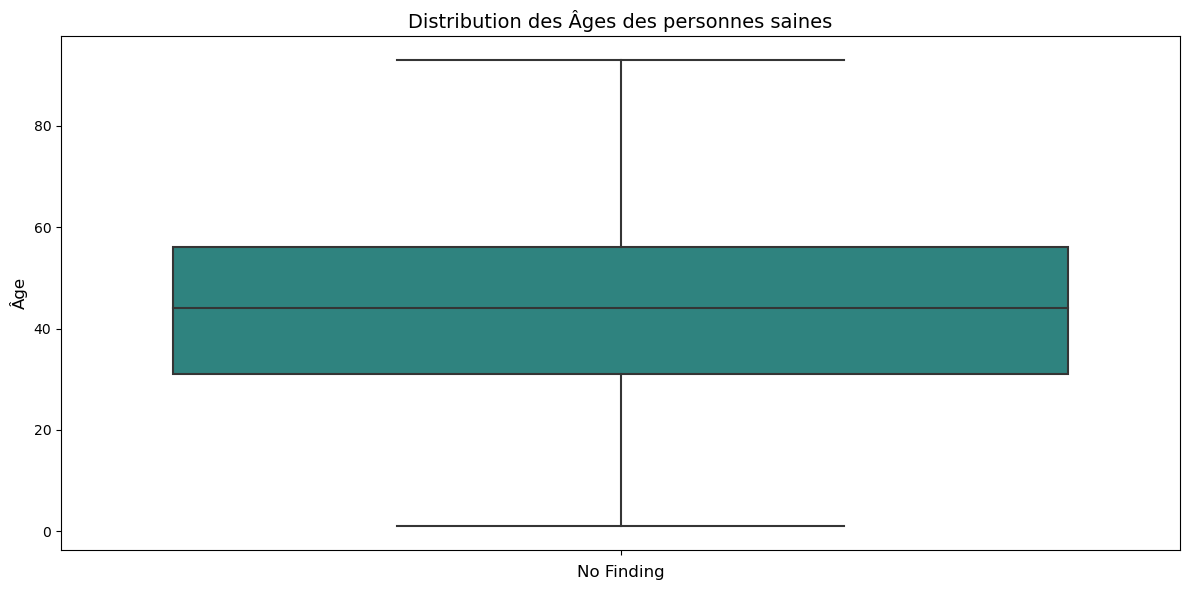

In [82]:
# Boxplot pour voir la distribution de l'âge par maladie
plt.figure(figsize=(12, 6))
sns.boxplot( y='Patient Age', data=df_no_outliers, palette='viridis')

# Ajouter des titres et labels
plt.title('Distribution des Âges des personnes saines', fontsize=14)
plt.xlabel('No Finding', fontsize=12)
plt.ylabel('Âge', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Verification "View Position" ne sert à rien

In [83]:
dict_max = {
    'Atelectasis': ['max'],
    'Cardiomegaly': ['max'],
    'Consolidation': ['max'],
    'Edema': ['max'],
    'Effusion': ['max'],
    'Emphysema': ['max'],
    'Fibrosis': ['max'],
    'Hernia': ['max'],
    'Infiltration': ['max'],
    'Mass': ['max'],
    'No Finding': ['max'],
    'Nodule': ['max'],
    'Pleural_Thickening': ['max'],
    'Pneumonia': ['max'],
    'Pneumothorax': ['max']
}
dict_sum = {k:['sum'] for k in dict_max.keys()}
diseases = list(dict_max.keys())

In [84]:
df_view = df.copy()
df_view["View Position"] = df_view["View Position"].map({"AP" : 0, "PA" : 1})


In [85]:
# Vérifier les types de données numériques
numerical_columns = df_view.select_dtypes(include=['number']).columns

# Vérification si la colonne 'Finding Labels' est bien une chaîne de caractères
if df_view["Finding Labels"].dtype != 'object':
    df_view["Finding Labels"] = df_view["Finding Labels"].astype(str)

# Appliquer 'get_dummies' sur la colonne 'Finding Labels' séparée par '|'
finding_labels = df_view["Finding Labels"].str.get_dummies(sep="|")

# Liste des nouvelles colonnes générées
labels = finding_labels.columns

# Fusionner les nouvelles colonnes binaires avec le DataFrame d'origine
df_view = pd.concat([df_view.drop(columns="Finding Labels"), finding_labels], axis=1)

# Afficher la forme du DataFrame après ajout des colonnes binaires
print(f"Shape of the DataFrame after adding dummy columns: {df_view.shape}")

df_view

Shape of the DataFrame after adding dummy columns: (54938, 25)


Image Index  Follow-up #  Patient ID  Patient Age Patient Gender  \
0      00000001_000.png            0           1           58              M   
1      00000001_001.png            1           1           58              M   
2      00000001_002.png            2           1           58              M   
3      00000005_000.png            0           5           69              F   
4      00000005_001.png            1           5           69              F   
...                 ...          ...         ...          ...            ...   
54933  00030794_000.png            0       30794           38              F   
54934  00030796_000.png            0       30796           44              M   
54935  00030802_000.png            0       30802           29              M   
54936  00030803_000.png            0       30803           42              F   
54937  00030804_000.png            0       30804           30              F   

       View Position  OriginalImage[Width  Height]  \
0                  1                 2682     2749   
1                  1                 2894     2729   
2                  1                 2500     2048   
3                  1                 2048     2500   
4                  0                 2500     2048   
...              ...                  ...      ...   
54933              1                 2021     2021   
54934              1                 2021     2021   
54935              1                 2048     2500   
54936              1                 2048     2500   
54937              1                 2048     2500   

       OriginalImagePixelSpacing[x        y]  ...  Emphysema  Fibrosis  \
0                         0.143000  0.143000  ...          0         0   
1                         0.143000  0.143000  ...          1         0   
2                         0.168000  0.168000  ...          0         0   
3                         0.168000  0.168000  ...          0         0   
4                         0.168000  0.168000  ...          0         0   
...                            ...       ...  ...        ...       ...   
54933                     0.194311  0.194311  ...          0         0   
54934                     0.194311  0.194311  ...          0         0   
54935                     0.168000  0.168000  ...          0         0   
54936                     0.168000  0.168000  ...          0         0   
54937                     0.168000  0.168000  ...          0         0   

       Hernia  Infiltration  Mass  No Finding  Nodule  Pleural_Thickening  \
0           0             0     0           0       0                   0   
1           0             0     0           0       0                   0   
2           0             0     0           0       0                   0   
3           0             0     0           1       0                   0   
4           0             0     0           1       0                   0   
...       ...           ...   ...         ...     ...                 ...   
54933       0             0     0           1       0                   0   
54934       0             0     0           1       0                   0   
54935       0             0     0           1       0                   0   
54936       0             0     0           1       0                   0   
54937       0             0     0           1       0                   0   

       Pneumonia  Pneumothorax  
0              0             0  
1              0             0  
2              0             0  
3              0             0  
4              0             0  
...          ...           ...  
54933          0             0  
54934          0             0  
54935          0             0  
54936          0             0  
54937          0             0  

[54938 rows x 25 columns]

In [86]:
#id_findings = df_view.groupby('Patient ID').agg( dict_max)
#id_findings.columns = [col[0] for col in id_findings.columns] 


In [87]:
#id_findings

In [88]:
print(df_view["View Position"].value_counts())

View Position
1    32466
0    22472
Name: count, dtype: int64


In [89]:
df_reversed_view = df_view.groupby(['View Position']).agg( dict_sum )
df_reversed_view.columns = [col[0] for col in df_reversed_view.columns] 
df_reversed_view = df_reversed_view.reset_index() 

df_reversed_view = df_reversed_view.groupby(['View Position']).agg( dict_sum ).reset_index()
df_reversed_view.columns = [col[0] for col in df_reversed_view.columns] 

df_reversed_view

View Position  Atelectasis  Cardiomegaly  Consolidation  Edema  Effusion  \
0              0         2887           613           1663   1063      3433   
1              1         2721           725            710    127      3196   

   Emphysema  Fibrosis  Hernia  Infiltration  Mass  No Finding  Nodule  \
0        543       167      15          5460   997       10445    1009   
1        749       660      96          4472  1612       19195    1970   

   Pleural_Thickening  Pneumonia  Pneumothorax  
0                 486        440           937  
1                1138        298          1608

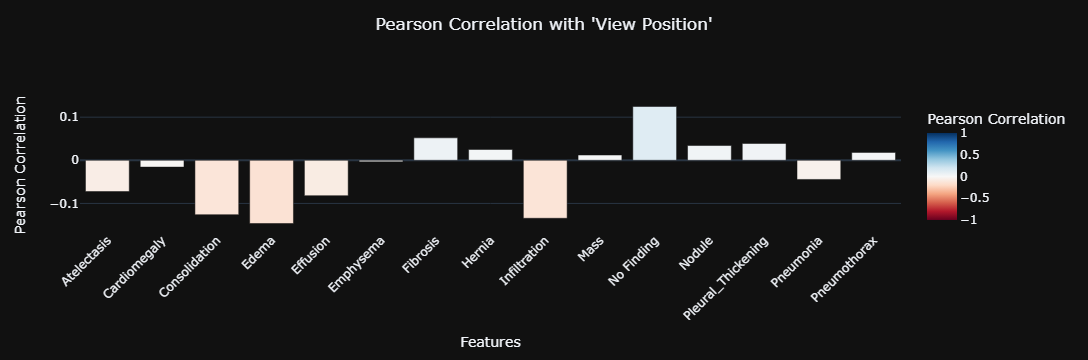

In [90]:
import plotly.express as px

def plot_column_correlation(df, target_column, label_columns):
    """
    Plots the Pearson correlation between a specific column and multiple label columns using Plotly.

    Parameters:
    - df: Pandas DataFrame.
    - target_column: Column name to compute correlations against.
    - label_columns: List of columns to compare with the target column.

    Returns:
    - A bar chart showing Pearson correlation values.
    """
    # Filter for numeric columns only to avoid errors
    numeric_columns = df[label_columns].select_dtypes(include=['number']).columns

    # Compute correlations for only numeric columns
    correlations = df[numeric_columns].corrwith(df[target_column])

    # Remove columns with NaN correlation values (i.e., constant columns or non-numeric)
    correlations = correlations.dropna()

    # Convert to DataFrame for Plotly
    corr_df = correlations.reset_index()
    corr_df.columns = ["Feature", "Correlation"]

    # Create a bar plot with color indicating correlation strength
    fig = px.bar(corr_df, 
                 x="Feature", 
                 y="Correlation", 
                 title=f"Pearson Correlation with '{target_column}'",
                 color="Correlation", 
                 color_continuous_scale='RdBu',  # Red-Blue color scale for negative and positive correlations
                 range_color=[-1, 1],  # Standard range for correlation
                 labels={"Correlation": "Pearson Correlation", "Feature": "Features"})

    # Customize plot appearance for readability
    fig.update_layout(
        yaxis_title="Pearson Correlation", 
        xaxis_title="Features",
        xaxis_tickangle=-45,  # Rotate x-axis labels for better readability
        title_x=0.5,  # Center the title
        title_y=0.95,  # Move the title up slightly
        template="plotly_dark",  # Dark theme for better contrast
        showlegend=False  # Hide the legend as the color scale is sufficient
    )

    # Add hover data for better interactivity
    fig.update_traces(
        hovertemplate="<b>%{x}</b><br>Corr: %{y:.3f}<br><extra></extra>"
    )

    fig.show()

# Exemple d'utilisation
plot_column_correlation(df_view, "View Position", diseases)


On voit clairement que la corrélation de pearson est trop proche de 0 pour qu'elle soit pris en considération. D'où la raison pour laquelle ça a été ignoré pendant l'étude.


Une simple recherche nous montrera que les view position de devant est nettement mieux qu'une de derrière qui ne sera prise de cette manière que si le patient est réellement souffrant (Vieux par exemple).

Donc, on pourra vite trouver une correlation si on s'y met mais ce n'est pas l'objectif que je veux atteindre. 



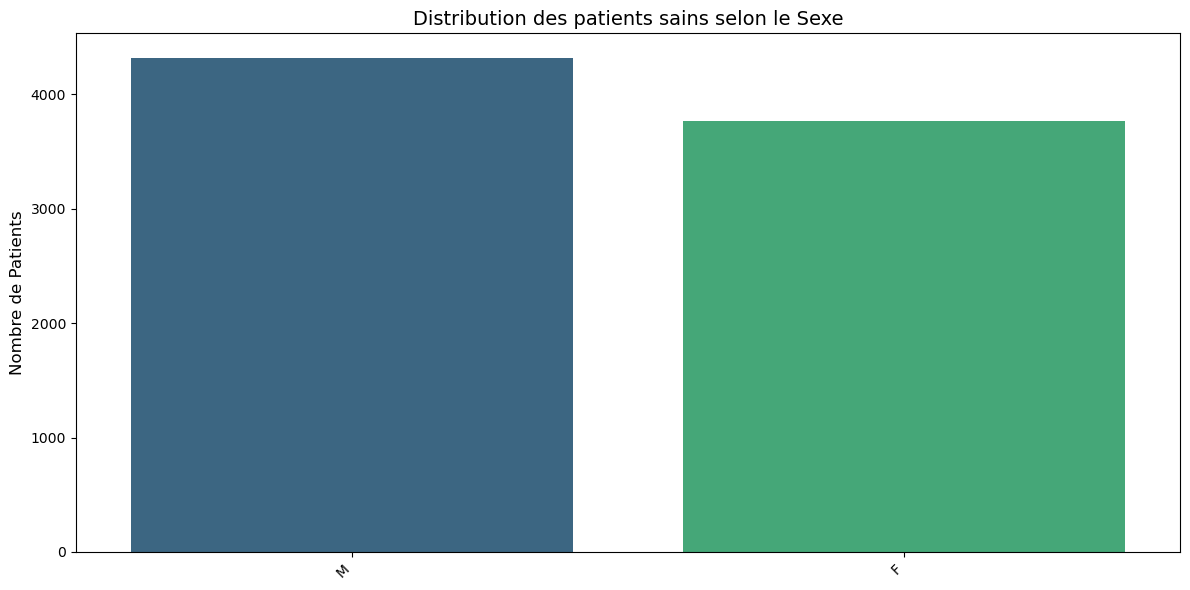

In [91]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Patient Gender', data=df_no_outliers, palette='viridis')

# Ajouter des titres et labels
plt.title('Distribution des patients sains selon le Sexe', fontsize=14)
plt.xlabel('', fontsize=12)
plt.ylabel('Nombre de Patients', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [92]:
#aléatoire over regression amplification of biases 

In [93]:
##Passer en one hot 

# Multi-class classification 
###### (Non testé car prend des lustres à charger parce que je suis sur jupyter en ligne mais quand j'aurai setup mon pc, vous serez tous impréssionés)

In [94]:
df_one_hot = df_pre_one_hot.copy()
# Créer une colonne 'Gender_Privileged' (1 pour M, 0 pour F)
df_one_hot["Patient Gender"] = df["Patient Gender"].map({"M": 1, "F": 0})
df["Patient Age"] = df["Patient Age"].apply(lambda x: 1 if x >= 50 else 0)  # Ex. âge privilégié >= 50


# Définir les colonnes des maladies (cibles)
df.columns = df.columns.str.strip()
disease_columns = [col for col in df_one_hot.columns if col.startswith("Maladies_")]

# Définir les attributs protégés
protected_attributes = ["Patient Age", "Patient Gender" ]
# Prétraitement des données
X = df_one_hot.drop(columns=["Patient ID"] + disease_columns)  # Exclure les attributs non pertinents
y = df_one_hot[disease_columns]  # Multi-label target

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [95]:
# Entraîner un modèle de régression logistique pour chaque maladie
models = {}
y_pred = pd.DataFrame(index=y_test.index)

#print("Répartition des genres dans X_test_df:")
#print(X_test_df["Gender_Privileged"].value_counts())

for disease in disease_columns:
    model = LogisticRegression(max_iter=100) #500
    model.fit(X_train, y_train[disease])
    models[disease] = model
    y_pred[disease] = model.predict(X_test)

    

In [96]:
for disease in disease_columns:
    print(f"\n=== Evaluating Bias for {disease} ===")
    X_test_df = pd.concat([X_test, y_test[disease]], axis=1)

    # Créer un dataset AIF360 spécifique à cette maladie
    dataset = StandardDataset(
        X_test_df,
        label_name=disease,  # Une seule maladie à la fois
        favorable_classes=[1],  
        protected_attribute_names=protected_attributes,
        privileged_classes=[[1], [1]],  # Both age and gender privileged classes
    )

    # Définir groupes privilégiés et non privilégiés pour les deux attributs
    priv_group = [{protected_attributes[0]: 1, protected_attributes[1]: 1}]  # Privileged: Age >= 50, Male
    unpriv_group = [{protected_attributes[0]: 0, protected_attributes[1]: 0}]  # Non-Privileged: Age < 50, Female

    # Calcul des métriques de biais
    classification_metric = ClassificationMetric(dataset, dataset, 
                                                 privileged_groups=priv_group, 
                                                 unprivileged_groups=unpriv_group)

    # Affichage des résultats
    group_metrics = get_group_metrics(
        y_test[disease],
        y_pred=y_pred[disease],
        prot_attr=protected_attributes,
        priv_group=1,
        pos_label=1,
        sample_weight=None,
    )
    print(group_metrics)



=== Evaluating Bias for Maladies_Atelectasis ===


KeyError: "None of ['Patient Age', 'Patient Gender'] are in the columns"

### y_columns= ['Maladies_Atelectasis',
           'Maladies_Cardiomegaly', 'Maladies_Consolidation', 'Maladies_Edema',
           'Maladies_Effusion', 'Maladies_Emphysema', 'Maladies_Fibrosis',
           'Maladies_Hernia', 'Maladies_Infiltration', 'Maladies_Mass',
           'Maladies_Nodule', 'Maladies_Pleural_Thickening', 'Maladies_Pneumonia',
           'Maladies_Pneumothorax']
# Define features and labels
X = df_pre_one_hot.drop(columns=y_columns, axis= 1 )  # Features
#X['Age_Privileged'] = np.where(X['Patient Age'] >= 50, 1, 0)
X['Gender_Privileged'] = np.where(X['Patient Gender'] == 'M', 1, 0)

X = X.drop(['Patient Gender'], axis=1)
y = df_pre_one_hot[y_columns].copy()  # Multi-label target (One-hot encoded)

# Split without stratification (best available option)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
X.columns
